<a href="https://colab.research.google.com/github/anshika3011/Dissertation/blob/main/Analysis_on_Quora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Loading the dataset
import pandas as pd
def load_dataset(file_path):
    data = pd.read_csv(file_path, sep=',', on_bad_lines='skip')
    return data


In [ ]:
data_quora = load_dataset('train.csv')

In [ ]:
data_quora.shape

(1306122, 3)

In [ ]:
data_quora.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


Exploratory Data analysis

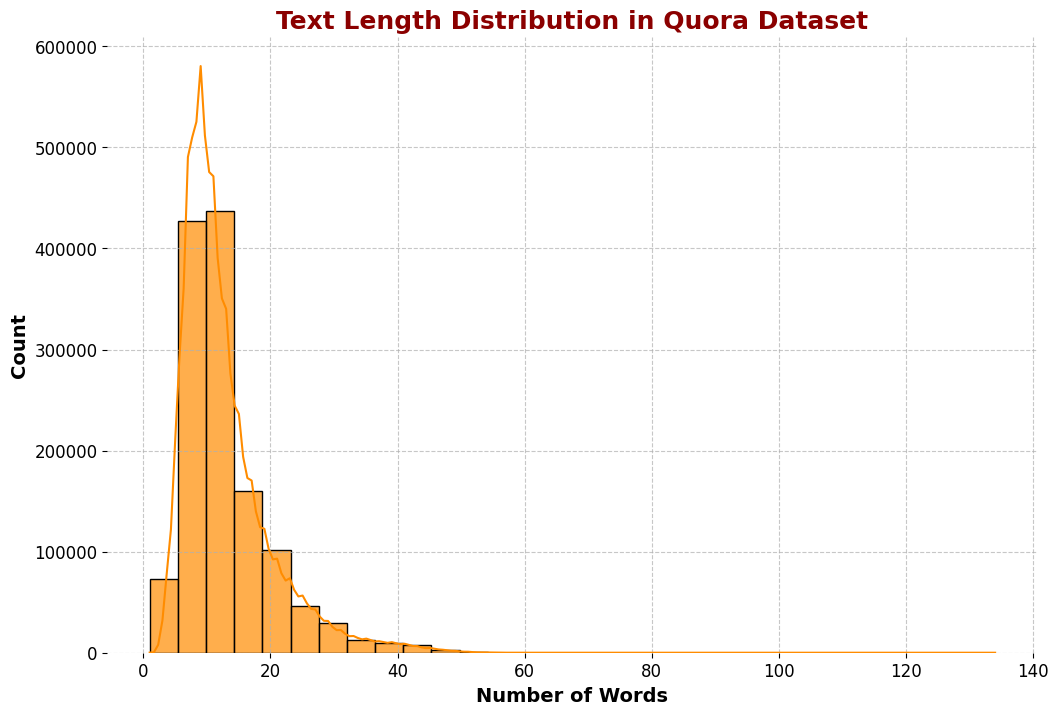

In [ ]:
# Calculating text length in terms of word count
import seaborn as sns
import matplotlib.pyplot as plt
#splits the question into text to calculate the length
data_quora['TextLength'] = data_quora['question_text'].apply(lambda x: len(x.split()))
#plotting the histogram
plt.figure(figsize=(12, 8))
sns.histplot(data_quora['TextLength'], kde=True, color='darkorange', bins=30, alpha=0.7)
plt.title('Text Length Distribution in Quora Dataset', fontsize=18, fontweight='bold', color='darkred')
plt.xlabel('Number of Words', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True, bottom=True)
plt.show()


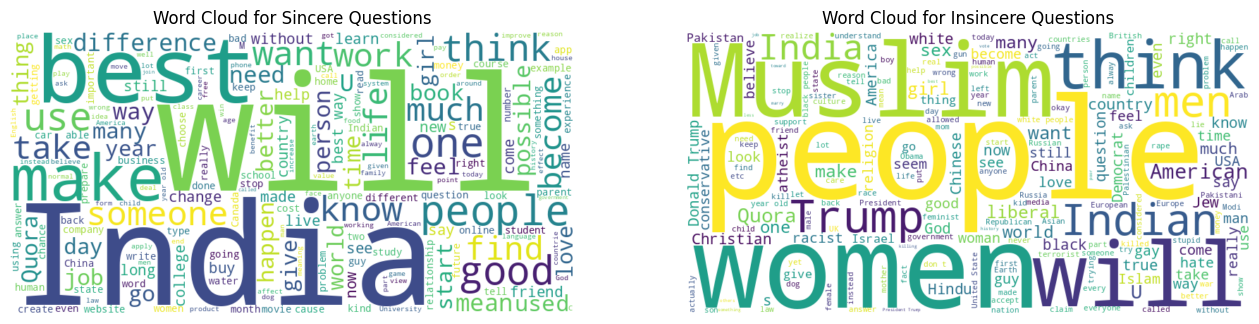

In [ ]:
#Generating a word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#word cloud for sincere questions
sincere_data = ' '.join(data_quora[data_quora['target'] == 0]['question_text'])
wordcloud_sincere_data = WordCloud(width=800, height=400, background_color='white').generate(sincere_data)

#word cloud for insincere questions
insincere_data = ' '.join(data_quora[data_quora['target'] == 1]['question_text'])
wordcloud_insincere_data = WordCloud(width=800, height=400, background_color='white').generate(insincere_data)

#Plotting the word clouds
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sincere_data, interpolation='bilinear')
plt.title('Word Cloud for Sincere Questions')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_insincere_data, interpolation='bilinear')
plt.title('Word Cloud for Insincere Questions')
plt.axis('off')
plt.show()


In [ ]:
#Preprocessing function to clean the text
import re
import string

def clean_text(text):
    #convert to lowercase
    text = text.lower()
    # Removing punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    #Removing digits
    text = re.sub(r'\d+', '', text)
    #Removing extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

APPLYING TRADITIONAL MACHINE LEARNING MODELS

Applying Logistic Regression with Polynomial Features

In [ ]:
#Calling data cleaning function
data_quora['Text'] = data_quora['question_text'].apply(clean_text)

#Calculating text length and number of special characters
data_quora['text_length'] = data_quora['Text'].apply(len)
data_quora['num_special_chars'] = data_quora['Text'].apply(lambda x: sum(1 for char in x if not char.isalnum()))

#Encoding target labels for binary classification
data_quora['target'] = data_quora['target'].map({0: 1, 1: 0})

In [ ]:
from sklearn.utils import resample
def balance_dataset(data, target_column):
    #Separate majority and minority classes
    df_majority = data[data[target_column] == 0]
    df_minority = data[data[target_column] == 1]

    #Downsample
    if len(df_majority) > len(df_minority):
        df_majority_downsampled = resample(df_majority,
                                           replace=False,
                                           n_samples=len(df_minority),
                                           random_state=42)
        data_balanced = pd.concat([df_majority_downsampled, df_minority])
    elif len(df_majority) < len(df_minority):
        df_minority_downsampled = resample(df_minority,
                                         replace=False,
                                         n_samples=len(df_majority),
                                         random_state=42)
        data_balanced = pd.concat([df_majority, df_minority_downsampled])
    else:
        data_balanced = data

    return data_balanced

In [ ]:
data_balanced = balance_dataset(data_quora, 'target')
#class distribution after balancing
print(data_balanced.target.value_counts())

target
0    80810
1    80810
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack
import itertools
import matplotlib.pyplot as plt

#Splitting data into training and testing sets
X = data_balanced['Text']
y = data_balanced['target']
X_features = data_balanced[['text_length', 'num_special_chars']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xtrain_features, xtest_features = train_test_split(X_features, test_size=0.2, random_state=42)

In [ ]:
#Converting words to numbers using TF-IDF
vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1, 2))
xtrain_tfidf = vectorizer.fit_transform(X_train)
xtest_tfidf = vectorizer.transform(X_test)

In [ ]:
#Adding polynomial features to the additional features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
xtrain_poly_features = poly.fit_transform(xtrain_features)
xtest_poly_features = poly.transform(xtest_features)

In [ ]:
#Combining TF-IDF and polynomial features
xtrain_combined = hstack([xtrain_tfidf, xtrain_poly_features])
xtest_combined = hstack([xtest_tfidf, xtest_poly_features])

In [ ]:
#Applying Logistic Regression classifier with hyperparameter tuning using GridSearch
param_grid = {'C': [0.1, 1, 10], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}
logit = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(logit, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(xtrain_combined, y_train)
best_logit = grid_search.best_estimator_

predicted_logit = best_logit.predict(xtest_combined)

Accuracy Score 
 0.8913500804355896
Confusion Matrix 
 [[14343  1748]
 [ 1764 14469]]
Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.89      0.89     16091
           1       0.89      0.89      0.89     16233

    accuracy                           0.89     32324
   macro avg       0.89      0.89      0.89     32324
weighted avg       0.89      0.89      0.89     32324



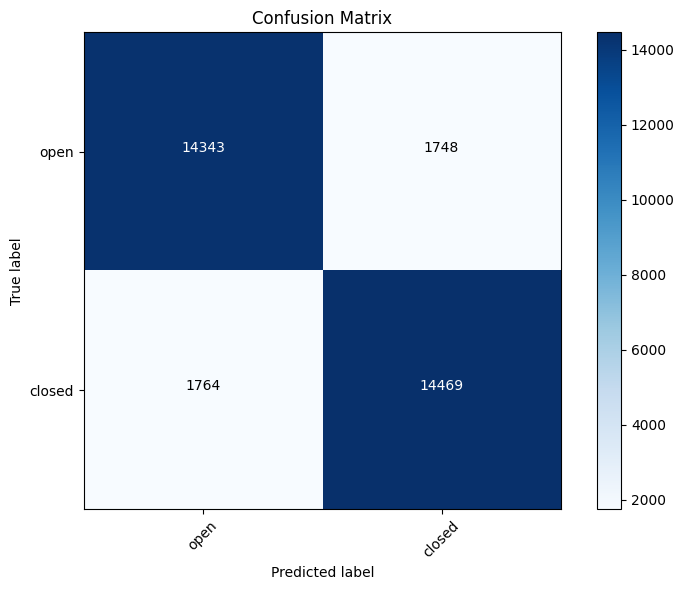

In [ ]:
#Evaluating the model
accuracy = accuracy_score(predicted_logit, y_test)
conf_matrix = confusion_matrix(predicted_logit, y_test)
class_report = classification_report(predicted_logit, y_test)

print('Accuracy Score \n', accuracy)
print('Confusion Matrix \n', conf_matrix)
print('Classification Report \n', class_report)

#Plotting confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['open', 'closed'], rotation=45)
plt.yticks(tick_marks, ['open', 'closed'])

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Using the stacking classifier

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack
import itertools
import matplotlib.pyplot as plt
#Loading the dataset
data_quora = load_dataset('train.csv')
#Calling data cleaning function
data_quora['Text'] = data_quora['question_text'].apply(clean_text)

#Calculating text length and number of special characters
data_quora['text_length'] = data_quora['Text'].apply(len)
data_quora['num_special_chars'] = data_quora['Text'].apply(lambda x: sum(1 for char in x if not char.isalnum()))

#Encoding target labels for binary classification
data_quora['target'] = data_quora['target'].map({0: 1, 1: 0})

In [ ]:
#Calling the balancing function
data_balanced = balance_dataset(data_quora, 'target')
print(data_balanced.target.value_counts())

#Splitting data into training and testing sets
X = data_balanced['Text']
y = data_balanced['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Converting words to numbers using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
xtrain_tfidf = vectorizer.fit_transform(X_train)
xtest_tfidf = vectorizer.transform(X_test)

target
0    80810
1    80810
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
#Define base models
base_models = [
    ('lr', LogisticRegression(max_iter=500, random_state=42)),
    ('nb', MultinomialNB()),
    ('dt', DecisionTreeClassifier(random_state=42))
]

#Define Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=500, random_state=42),
    cv=3,
    n_jobs=-1
)

#Training the Stacking Classifier
stacking_clf.fit(xtrain_tfidf, y_train)

predicted_stack = stacking_clf.predict(xtest_tfidf)



Accuracy Score 
 0.8856577156292538
Confusion Matrix 
 [[14316  1905]
 [ 1791 14312]]
Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.88      0.89     16221
           1       0.88      0.89      0.89     16103

    accuracy                           0.89     32324
   macro avg       0.89      0.89      0.89     32324
weighted avg       0.89      0.89      0.89     32324



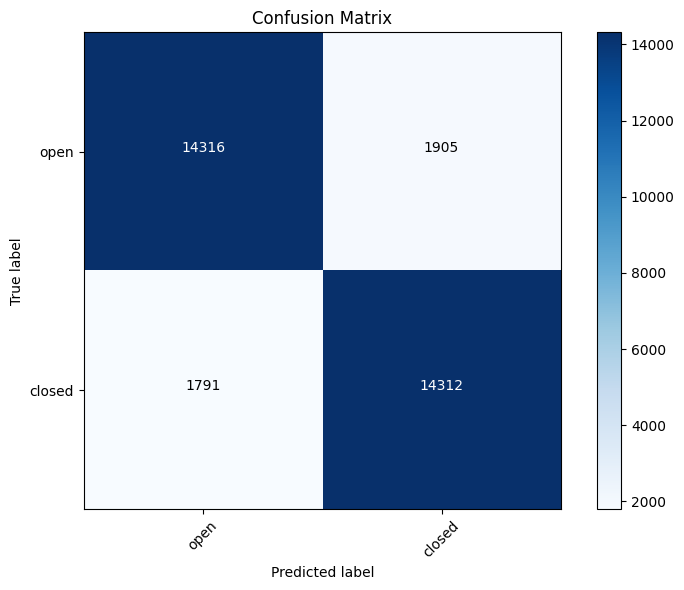

In [ ]:
#Evaluating the Stacking Classifier
accuracy = accuracy_score(predicted_stack, y_test)
conf_matrix = confusion_matrix(predicted_stack, y_test)
class_report = classification_report(predicted_stack, y_test)

print('Accuracy Score \n', accuracy)
print('Confusion Matrix \n', conf_matrix)
print('Classification Report \n', class_report)

#Plotting confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['open', 'closed'], rotation=45)
plt.yticks(tick_marks, ['open', 'closed'])

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

APPLYING DECODER BASED MODELS

Applying BERT

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from transformers import AutoTokenizer, TFBertForSequenceClassification
from sklearn.utils import resample

#checking GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#Loading the dataset
data_quora = load_dataset('train.csv')
#Calling data cleaning function
data_quora['Text'] = data_quora['question_text'].apply(clean_text)

#Calculating text length and number of special characters
data_quora['text_length'] = data_quora['Text'].apply(len)
data_quora['num_special_chars'] = data_quora['Text'].apply(lambda x: sum(1 for char in x if not char.isalnum()))

#Encoding target labels for binary classification
data_quora['target'] = data_quora['target'].map({0: 1, 1: 0})

Num GPUs Available:  1


In [ ]:
#Calling the balancing function
data_balanced = balance_dataset(data_quora, 'target')
print(data_balanced.target.value_counts())

#Splitting data into training and testing sets
X = data_balanced['question_text']
y = data_balanced['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

target
0    80810
1    80810
Name: count, dtype: int64


In [ ]:
#Loading the pre-trained BERT model tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def encode_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts.tolist(),
        max_length=max_length,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )

In [ ]:
#Calling the encode_texts function
x_train_encoded = encode_texts(X_train, tokenizer)
x_test_encoded = encode_texts(X_test, tokenizer)

In [ ]:
#Loading the pre-trained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

#Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Prepare datasets
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((dict(x_train_encoded), y_train)).shuffle(10000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(x_test_encoded), y_test)).batch(batch_size)

#Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

#Train the model
history = model.fit(
    train_dataset,
    epochs=3,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

Epoch 1/3
4041/4041 [==============================] - 1175s 281ms/step - loss: 0.2397 - accuracy: 0.9091 - val_loss: 0.2213 - val_accuracy: 0.9162
Epoch 2/3
4041/4041 [==============================] - 1132s 280ms/step - loss: 0.1560 - accuracy: 0.9451 - val_loss: 0.2247 - val_accuracy: 0.9255
Epoch 3/3
4041/4041 [==============================] - 1133s 280ms/step - loss: 0.0924 - accuracy: 0.9691 - val_loss: 0.2604 - val_accuracy: 0.9203


In [ ]:
#Predict on validation dataset
val_predictions_proba = model.predict(test_dataset)
val_predictions_proba = tf.nn.softmax(val_predictions_proba.logits, axis=-1)[:, 1].numpy()
#Calculating ROC curve
fpr, tpr, thresholds = roc_curve(y_test, val_predictions_proba)
roc_auc = auc(fpr, tpr)

#Determining the predictions based on a threshold  of 0.5
val_predictions = (val_predictions_proba > 0.5).astype(int)

#Model Evaluation using Accuracy, Confusion Matrix, and Classification Report
accuracy = accuracy_score(y_test, val_predictions)
conf_matrix = confusion_matrix(y_test, val_predictions)
class_report = classification_report(y_test, val_predictions)

print('Accuracy Score \n', accuracy)
print('Confusion Matrix \n', conf_matrix)
print('Classification Report \n', class_report)

1011/1011 [==============================] - 89s 85ms/step
Accuracy Score 
 0.9161613661675535
Confusion Matrix 
 [[15435   672]
 [ 2038 14179]]
Classification Report 
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     16107
           1       0.95      0.87      0.91     16217

    accuracy                           0.92     32324
   macro avg       0.92      0.92      0.92     32324
weighted avg       0.92      0.92      0.92     32324



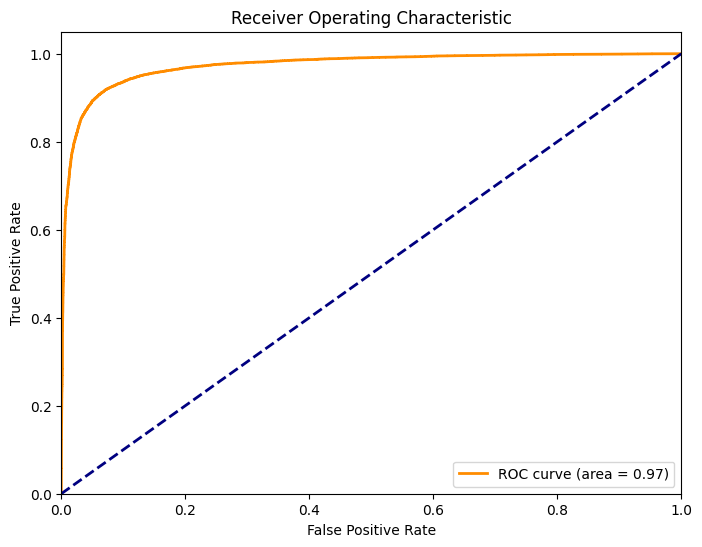

In [ ]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

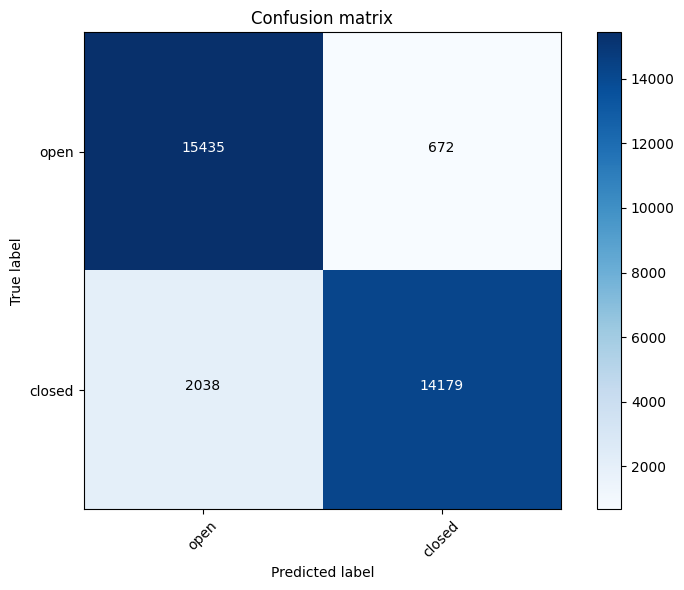

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['open', 'closed'], rotation=45)
plt.yticks(tick_marks, ['open', 'closed'])

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Applying XML-R

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import resample
import tensorflow as tf
from transformers import AutoTokenizer, TFXLMRobertaForSequenceClassification

#checking GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#Loading the dataset
data_quora = load_dataset('train.csv')
#Calling data cleaning function
data_quora['Text'] = data_quora['question_text'].apply(clean_text)

#Calculating text length and number of special characters
data_quora['text_length'] = data_quora['Text'].apply(len)
data_quora['num_special_chars'] = data_quora['Text'].apply(lambda x: sum(1 for char in x if not char.isalnum()))

#Encoding target labels for binary classification
data_quora['target'] = data_quora['target'].map({0: 1, 1: 0})

Num GPUs Available:  1


In [ ]:
#Calling the balancing function
data_balanced = balance_dataset(data_quora, 'target')
print(data_balanced.target.value_counts())

#Splitting data into training and testing sets
X = data_balanced['question_text']
y = data_balanced['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

target
0    80810
1    80810
Name: count, dtype: int64


In [ ]:
x_train_encoded = encode_texts(X_train, tokenizer, 64)
x_test_encoded = encode_texts(X_test, tokenizer, 64)
#Enabling mixed precision for faster training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [ ]:
#Loading the pre-trained BERT model for sequence classification
model = TFXLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)

#Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFXLMRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFXLMRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Prepare datasets
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((dict(x_train_encoded), y_train)).shuffle(10000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(x_test_encoded), y_test)).batch(batch_size)

#Defining callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)

#rain the model
history = model.fit(
    train_dataset,
    epochs=3,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

Epoch 1/3
8081/8081 [==============================] - 830s 103ms/step - loss: 0.2630 - accuracy: 0.8992 - val_loss: 0.2919 - val_accuracy: 0.8913
Epoch 2/3
8081/8081 [==============================] - 824s 102ms/step - loss: 0.2337 - accuracy: 0.9119 - val_loss: 0.2911 - val_accuracy: 0.8958
Epoch 3/3
8081/8081 [==============================] - 821s 102ms/step - loss: 0.2081 - accuracy: 0.9233 - val_loss: 0.2902 - val_accuracy: 0.8947


2021/2021 [==============================] - 47s 23ms/step - loss: 0.2902 - accuracy: 0.8947
Validation Loss: 0.29017961025238037, Validation Accuracy: 0.8946602940559387
2021/2021 [==============================] - 46s 23ms/step
Accuracy Score 
 0.894660314317535
Confusion Matrix 
 [[14619  1543]
 [ 1862 14300]]
Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.90      0.90     16162
           1       0.90      0.88      0.89     16162

    accuracy                           0.89     32324
   macro avg       0.89      0.89      0.89     32324
weighted avg       0.89      0.89      0.89     32324



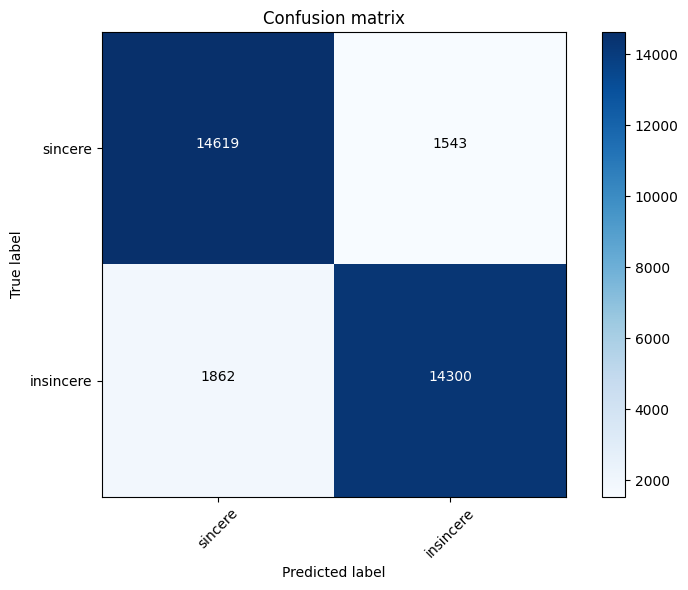

In [ ]:
#Evaluating the XLM-R model
val_loss, val_accuracy = model.evaluate(test_dataset)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

#Predicting on validation dataset
val_predictions = model.predict(test_dataset)
val_predictions = np.argmax(val_predictions.logits, axis=1)

#Model Evaluation
accuracy = accuracy_score(y_test, val_predictions)
conf_matrix = confusion_matrix(y_test, val_predictions)
class_report = classification_report(y_test, val_predictions)

print('Accuracy Score \n', accuracy)
print('Confusion Matrix \n', conf_matrix)
print('Classification Report \n', class_report)

#Plotting confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['sincere', 'insincere'], rotation=45)
plt.yticks(tick_marks, ['sincere', 'insincere'])

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()